In [ ]:
from dotenv import load_dotenv
import os
from azure.identity import DefaultAzureCredential,get_bearer_token_provider
from langchain_openai import AzureChatOpenAI
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from typing  import Literal,Sequence,Annotated,TypedDict
import operator
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph,START,END


load_dotenv()



os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")  # Update to your API key
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_APIKEY")


token_provider= get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")
model= AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    azure_deployment= "gpt-4o-mini"
)
model.invoke("HI").content


In [ ]:
@tool
def multiply(a:int,b:int):
    """ This tool will multiply the given two imput and return the response"""
    return a*b


@tool
def search(query:str):
    """search the web for a query and return the respone"""
    web_results= TavilySearchResults(max_results=1).invoke(query)
    return f"Result for {query} is ::  {web_results}"

In [ ]:
multiply.invoke({"a":2,"b":3})
search.invoke({"query":"Capital of India"})

In [ ]:
tools = [multiply,search ]
llm_with_tool = model.bind_tools(tools= tools)
result = llm_with_tool.invoke("What is the current GDP of India?")
result

In [ ]:
tool_mapping = {tool.name:tool for tool in tools}
tool_mapping

In [ ]:
tool_mapping[result[0]["name"]].invoke("What is the capital of India")

In [ ]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage],operator.add]

In [22]:
def invoke_model(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    result = llm_with_tool.invoke(last_message)
    #state["messages"].append(result)
    return {"messages":[result]}

def invoke_tool(state: AgentState):
    tool_calls = state["messages"][-1].tool_calls
    print(f"selected tool : {tool_calls[0]['name']}")
    if tool_calls[0]['name'] == "search":
        response = input(prompt=f"[yes/no] Do you want to call tavily")
        if response.lower() == "no":
            print("rejected")
            raise Exception("Web Search discrded by the user")
    response = tool_mapping[tool_calls[0]['name']].invoke(tool_calls[0]['args']) 
    return {"messages":[response]}      


def router(state: AgentState):
    tool_calls = state["messages"][-1].tool_calls
    if len(tool_calls)>0 :
        return "tool"
    else :
        return END

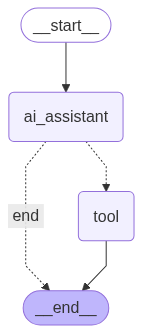

In [23]:
graph=StateGraph(AgentState)
graph.add_node("ai_assistant",invoke_model)
graph.add_node("tool",invoke_tool)
graph.add_conditional_edges(
    "ai_assistant",
    router,
    {
        "tool" : "tool",
        "end": END
    })
graph.add_edge("tool",END)
graph.add_edge(START,"ai_assistant")
compiledgraph= graph.compile()
compiledgraph

In [26]:
compiledgraph.invoke({"messages":["What is the current GDP of India?"]})

selected tool : search


{'messages': ['What is the current GDP of India?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EMg6jwA7IzeXuur9nIQIa3uh', 'function': {'arguments': '{"query":"current GDP of India 2023"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 86, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_57db37749c', 'id': 'chatcmpl-BndgWJNLh1IV9rDgion7jkmz6cWgb', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity

In [27]:
compiledgraph.invoke({"messages":["Multiply 2 with 3"]})

selected tool : multiply


{'messages': ['Multiply 2 with 3',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EjH9oxG1l6zxiErKgpPMcCpS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 84, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-BndhNoaDtUBiCoGY3cfxkaboc0LKx', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': F